# Vision Transformer for Classification

In [3]:
# !pip install transformers

In [1]:
import os
import requests
import tarfile
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
from torchvision.transforms import v2
import torch
import PIL.Image
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import default_collate

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [2]:
import random
def seed_all(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_all()

## Data Preprocess

In [3]:
data_dir = "/kaggle/input/animal/Dataset"

image_size = 224
batch_size = 32
cutmix = v2.CutMix(num_classes=20)
mixup = v2.MixUp(num_classes=20)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

# We resize the images to [3,64,64]
transform = v2.Compose([v2.Resize((image_size,image_size)),  #resises the image so it can be perfect for our model.
                        v2.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
#                         v2.RandomRotation(4), #Rotates the image to a specified angel
#                         v2.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
#                         v2.AutoAugment(),
                        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                        v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the images, each R,G,B value is normalized with mean=0.5 and std=0.5
                                      ])


# Load the dataset using torchvision.datasets.ImageFolder and apply transformations
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split the dataset into training and validation sets
train_size = int(.99 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, valid_size])

# Example of DataLoader creation for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Number of instance in train_set: %s" % len(train_dataset))
print("Number of instance in val_set: %s" % len(val_dataset))

Number of instance in train_set: 9371
Number of instance in val_set: 95


In [4]:
class_names = ['birds', 'bottles', 'breads', 'butterflies', 'cakes', 'cats', 'chickens', 'cows', 'dogs', 'ducks',
                  'elephants', 'fishes', 'handguns', 'horses', 'lions', 'lipsticks', 'seals', 'snakes', 'spiders', 'vases']

## Define Models

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the Model

### Model Selection

In [6]:

from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = "google/vit-base-patch16-224-in21k"

num_classes = 20  # Number of classes in your dataset
model = ViTForImageClassification.from_pretrained(model_name, num_labels=20, ignore_mismatched_sizes=True)


# Freeze all layers 
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze last layer
for param in model.classifier.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.DataParallel(model)
model = model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
print(model)

DataParallel(
  (module): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
      

### Trainer and required function

In [8]:
def top_k_accuracy(output, target, k=5):
    batch_size = target.size(0)
    _, pred = output.topk(k, 1, True, True)  # Get top-k predictions
    pred = pred.t()  # Transpose predictions for comparison
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))  # Compare predictions with target
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)  # Calculate correct top-k
    return correct_k.mul_(1.0 / batch_size).item()  # Calculate top-k accuracy

class BaseTrainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, is_cutmix_mixup = False, is_pgd_attack = False, lambda_reg=0.01 ,regularization_type = 'L1'):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.stop_training = False
        self.is_cutmix_mixup = is_cutmix_mixup # cutmix / mixup
        self.lambda_reg = lambda_reg
        self.regularization_type = regularization_type
        self.is_pgd_attack = is_pgd_attack
        self.history = dict()
        self.history['val_loss'] = list()
        self.history['val_acc'] = list()
        self.history['train_loss'] = list()
        self.history['train_acc'] = list()
    
    def get_history(self):
        return self.history
    
    def fit(self, num_epochs):
        self.num_batches = len(self.train_loader)
        for epoch in range(num_epochs):
            if self.stop_training:
                break
            print(f'Epoch {epoch + 1}/{num_epochs}:')
            start = time.time()
            train_loss, train_accuracy = self.train_one_epoch()
            val_loss, top1_acc, top5_acc = self.validate_one_epoch()
            end = time.time()
            print(f"|- Total time: {end - start:.2f} seconds") # time in seconds
            print(
                f'|- train_loss: {train_loss:.4f} - train_accuracy: {train_accuracy*100:.4f}% - val_loss: {val_loss:.4f} - top1_acc: {top1_acc*100:.4f}% - top5_acc: {top5_acc*100:.4f}%'
            )
            self.on_epoch_end({'epoch': epoch, 
                               'train_loss': train_loss, 
                               'train_accuracy': train_accuracy*100, 
                               'val_loss': val_loss, 
                               'val_accuracy': top1_acc*100, 
                               'top5_acc': top5_acc*100})

    def train_one_epoch(self):
        self.model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i, data in enumerate(self.train_loader):
            
            inputs, labels = data
            if self.is_cutmix_mixup:
                inputs, labels = cutmix_or_mixup(inputs, labels) # for cutmix/mixup
            
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            
            if self.is_pgd_attack: 
                inputs_adv = pgd_attack(self.model, inputs, labels)
                outputs = self.model(inputs)
                outputs_adv = self.model(inputs_adv)
                loss = (self.criterion(outputs, labels) + self.criterion(outputs_adv, labels)) / 2
            else:
                outputs = self.model(inputs).logits
                loss = self.criterion(outputs, labels)
                
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            
            if self.is_cutmix_mixup:
                correct += (predicted == torch.argmax(labels)).sum().item() # for cutmix/mixup
            else: 
                correct += (predicted == labels).sum().item()


        train_accuracy = correct / total
        train_loss = running_loss / self.num_batches
        return train_loss, train_accuracy

    def validate_one_epoch(self):
        self.model.eval()
        val_loss, correct, total_top1_acc, total_top5_acc, total = 0.0, 0, 0.0, 0.0, 0
        
        with torch.no_grad():
            for data in self.val_loader:
                inputs, labels = data
                
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs).logits
                loss = self.criterion(outputs, labels) 
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

                top1_acc = top_k_accuracy(outputs, labels, k=1)
                top5_acc = top_k_accuracy(outputs, labels, k=5)

                total_top1_acc += top1_acc * inputs.size(0)  # Custom evaluation metric
                total_top5_acc += top5_acc * inputs.size(0)  # Custom evaluation metric
                total += labels.size(0)

        val_loss /= len(self.val_loader)
        top1_acc = total_top1_acc / total
        top5_acc = total_top5_acc / total
        return val_loss, top1_acc, top5_acc

    def on_epoch_end(self, params):
        self.history['train_loss'].append(params['train_loss'])
        self.history['train_acc'].append(params['train_accuracy'])
        self.history['val_loss'].append(params['val_loss'])
        self.history['val_acc'].append(params['val_accuracy'])

#### <span style="color:#0b486b">4. Declaring the Loss, Optimizer, learning rate and Training the Model </span>

In [9]:
# Base warm up model

optimizer = torch.optim.NAdam(model.parameters(), lr=1e-3)
criterion=nn.CrossEntropyLoss()
trainer = BaseTrainer(model, criterion, optimizer, train_loader, val_loader)
trainer.fit(num_epochs=5)

Epoch 1/5:


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


|- Total time: 161.25 seconds
|- train_loss: 0.7243 - train_accuracy: 97.2788% - val_loss: 0.1075 - top1_acc: 100.0000% - top5_acc: 100.0000%
Epoch 2/5:
|- Total time: 136.19 seconds
|- train_loss: 0.1001 - train_accuracy: 99.4024% - val_loss: 0.0311 - top1_acc: 100.0000% - top5_acc: 100.0000%
Epoch 3/5:
|- Total time: 137.43 seconds
|- train_loss: 0.0396 - train_accuracy: 99.7225% - val_loss: 0.0145 - top1_acc: 100.0000% - top5_acc: 100.0000%
Epoch 5/5:
|- Total time: 137.07 seconds
|- train_loss: 0.0296 - train_accuracy: 99.7012% - val_loss: 0.0079 - top1_acc: 100.0000% - top5_acc: 100.0000%


In [11]:
# Save model
# !mkdir -p ./models
# model_path = './models/ViT384_warmUp_epoch5_lr1e-3_DefaultAugmentation.pt'

# torch.save(model.state_dict(), model_path)

In [12]:
num_classes = 20  # Number of classes in your dataset
model = ViTForImageClassification.from_pretrained(model_name, num_labels=20, ignore_mismatched_sizes=True) 
# Define the image feature extractor
feature_extractor = ViTFeatureExtractor(model_name)

# UnFreeze all layers 
for param in model.parameters():
    param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = nn.DataParallel(model)
# model.load_state_dict(torch.load("/kaggle/input" + model_path[1:]))
# model.load_state_dict(torch.load(model_path))

model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=5e-4, momentum=0.9)
criterion=nn.CrossEntropyLoss()
trainer = BaseTrainer(model, criterion, optimizer, train_loader, val_loader)
trainer.fit(num_epochs=3)

Epoch 1/3:
|- Total time: 232.94 seconds
|- train_loss: 2.6617 - train_accuracy: 71.3051% - val_loss: 2.2361 - top1_acc: 100.0000% - top5_acc: 100.0000%
Epoch 2/3:
|- Total time: 240.28 seconds
|- train_loss: 1.7885 - train_accuracy: 98.5167% - val_loss: 1.2143 - top1_acc: 100.0000% - top5_acc: 100.0000%
Epoch 3/3:
|- Total time: 232.66 seconds
|- train_loss: 0.8671 - train_accuracy: 99.2530% - val_loss: 0.4933 - top1_acc: 100.0000% - top5_acc: 100.0000%


#### <span style="color:#0b486b">5. Visualizing the Performance and Loss Objective Function </span>

There are four keys in the history dictionary: `train_loss` and `val_loss` measure the loss on the training set and the validation set, respectively, while `train_acc` and `val_acc` measure the accuracy on the training set and the validation set.  
The following figure visualize all four metrics with two y-axes, losses (blue lines, in descending) and accuracies (red lines, in asending)


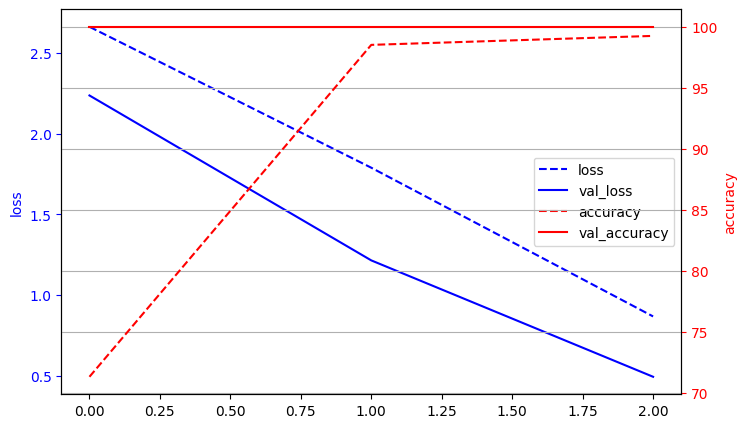

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

his = trainer.history
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['train_loss'], 'b--',label='loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['train_acc'], 'r--',label='accuracy')
ln4 = ax2.plot(his['val_acc'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")

lns = ln1 + ln2 + ln3 + ln4
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc=7)
plt.grid(True)
plt.show()

In [18]:
# # Save model (after warm up)
# !mkdir -p ./models
# model_path = './models/ViT_trainedWithWarmUp_epoch10_lr5e-4_NoAugmentation.pt'
# torch.save(model.state_dict(), model_path)